In [1]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.colors as colors

In [3]:
##Join PCP_max archives
os.chdir('D:\\Bigfiles\\RACMO2_PCP')
lats = np.genfromtxt('PCP_max_lats.csv', delimiter=';')
lons = np.genfromtxt('PCP_max_lons.csv', delimiter=';')
duration = np.genfromtxt('PCP_max_duration.csv', delimiter=';')

PCP_max = np.zeros((lats.shape[0], lats.shape[1], 20))
PCP_mean = np.zeros((lats.shape[0], lats.shape[1], 20))


files = 'PCP_max_*d.csv'
for i,file in enumerate(glob.glob(files)):
    print(file)
    PCP_max[:,:,i] = np.genfromtxt(file, delimiter=';')

files = 'PCP_mean_*d.csv'
for i,file in enumerate(glob.glob(files)):
    print(file)
    PCP_mean[:,:,i] = np.genfromtxt(file, delimiter=';')


    
Ant_max = np.max(np.max(PCP_max, axis=0), axis=0)
Ant_mean = np.mean(np.mean(PCP_mean, axis=0), axis=0)
print(Ant_max)
print(duration)

IndexError: tuple index out of range

ANTARCTICA
a = 3.5026062837301244
a_sup = [4.36030597], a_inf = [2.88945357]
b = 0.5809380145493747
[  298.07791566   445.87135163   564.29691388   666.94394908
   759.25567598   844.08744993   923.16510094   997.62909095
  1068.28111135  1135.71095574  1437.36121427  1698.82085284
  2150.03579168  3216.06973921  4070.2732347   6088.40217037
  7705.51088926  9107.16279981 11526.0687715  13622.68981934]
[0.02865838 0.06131942 0.06397806 0.01173356 0.00783974 0.00197913
 0.10753387 0.16639876 0.12557381 0.0247746 ]
[  239.44410967   358.16564465   453.29615189   535.75186786
   609.90529588   678.05012485   741.57270317   801.3891567
   858.14347908   912.3094478   1154.62319796  1364.65207659
  1727.11019114  2583.4485377   3269.62481815  4890.77506379
  6189.78829854  7315.72643805  9258.81834902 10943.02081332]
WR
a = 53.452103925694374
a_sup = [73.25969403], a_inf = [40.4525376]
b = 0.4846728478249487
[7.32596940e+01 1.80956853e+05]
[0.13529903 0.00273326 0.09256119 0.06301041 0.0032

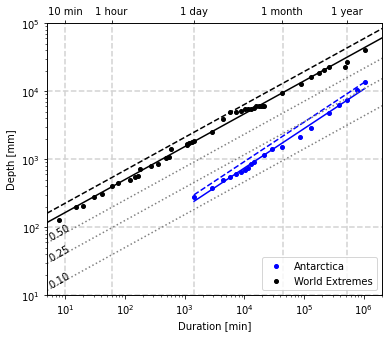

In [16]:
######################################
# Plot Scaling Law of Continental Max
######################################

#Obtain max array
Ant_max = np.max(np.max(PCP_max, axis=0), axis=0)

class SL_Envelop():
    '''----BASIC METHODS----'''
    def __init__(self, duration, record):
        self._duration = duration
        self._record = record
        
    @property
    def duration (self):
        return self._duration     
    
    @property
    def record (self):
        return self._record
     
    def __str__(self):
        return 'DATA\n Duration: ' + self.duration + '\n Record: ' + self.record
    
    def regression(self, complete=False, ftype=0):
        '''Log-Log regression of data'''
        #Fit in log domain
        p = np.polyfit(np.log(self.duration),np.log(self.record),1)
        
        #Compute fit in linear domain (y = e^(p_1 * log(x) + p_2)
        if complete == False:
            y_hat = np.exp(p[0] * np.log(self.duration) + p[1])
        else:
            y_hat = np.exp(p[0] * np.log([1,10000000]) + p[1])
        
        if ftype == 3:
            return y_hat, p[1], p[0]
        elif ftype == 2:
            return p[1], p[0]      
        elif ftype == 1:
            return np.exp(p[1]), p[0]
        else:
            return y_hat, p
    
    def envelope(self, opt='both', range=[1,10000000], complete=False):
        '''Envelop of the supINSay data'''
        
        #Make the regression
        y_hat, a, b = self.regression(complete=False, ftype=3)
        
        #Superior Envelop
        Log_record_sup = np.log(self.record[np.where(self.record > y_hat)])
        Log_duration_sup = np.log(self.duration[np.where(self.record > y_hat)])
        dist = np.abs(b*Log_duration_sup - Log_record_sup + a) / np.sqrt(b**2 + 1)
        Max_record_sup = Log_record_sup[np.where(dist == np.amax(dist))]
        Max_duration_sup = Log_duration_sup[np.where(dist == np.amax(dist))]
        a_sup = b*(-Max_duration_sup) + Max_record_sup

        #Inferior Envelop
        Log_record_inf = np.log(self.record[np.where(self.record < y_hat)])
        Log_duration_inf = np.log(self.duration[np.where(self.record < y_hat)])
        dist = np.abs(b*Log_duration_inf - Log_record_inf + a) / np.sqrt(b**2 + 1)
        Max_record_inf = Log_record_inf[np.where(dist == np.amax(dist))]
        Max_duration_inf = Log_duration_inf[np.where(dist == np.amax(dist))]
        a_inf = b*(-Max_duration_inf) + Max_record_inf

        
        #Calculate the Envelope ecuation
        if complete == False:
            y_hat_sup = np.exp(b * np.log(self.duration) + a_sup)
            y_hat_inf = np.exp(b * np.log(self.duration) + a_inf)
        else:
            y_hat_sup = np.exp(b * np.log(range) + a_sup)
            y_hat_inf = np.exp(b * np.log(range) + a_inf)
        
        print('a_sup = ' + str(np.exp(a_sup)) + ', a_inf = ' + str(np.exp(a_inf)))
        print('b = ' + str(b))
        print(y_hat_sup)
        print(dist)
        
        return y_hat_sup, y_hat_inf, a_sup, a_inf, b
        
        #return env_sup, env_inf 
        
    
    def formula(self, ftype=0):
        '''Show formula of regression'''
        _reg, p = self.regression()
        R2 = self.R2()
        b = p[0]
        a = np.exp(p[1])        
        
        #formula = 'y = '+str(np.round(a,2))+' EXP(x^'+str(np.round(b,2))+')'
        if ftype == 0:
            formula = '$y = '+str(np.round(a,2))+' x^{'+str(np.round(b,2))+'}$'
        elif ftype == 1:
            formula = '$b:'+str(np.round(b,2))+'$'
        elif ftype == 2:
            formula = '$b:'+str(np.round(b,2))+' a:'+str(np.round(a,2))+'$'
        elif ftype == 3:
            formula = '$R^{2}:'+str(np.round(R2,2))+'$'
        
        return formula
    
    def exponent(self):
        _reg, p = self.regression()
        b = p[0]
        
        return b
    
    def R2(self):
        X = np.log(np.array(self.duration))
        Y = np.log(np.array(self.record))
        n = np.size(X)
        A = np.sum(X*Y) - 1/n * np.sum(X) * np.sum(Y)
        B = np.sum(X**2) - 1/n * np.sum(X)**2
        C = np.sum(Y**2) - 1/n * np.sum(Y)**2
        
        return A**2 / (B*C)
    
       
def plot_scaling_law():    
    #SETTING LINES##
    #Axis
    fig = plt.figure(figsize=(6,5))
    ax = fig.gca()
    ylines = [10,100,1000,10000]
    xlines = [10,60,1440,44640,525600]
    for yline in ylines:
        ax.axhline(yline, linestyle='--', linewidth=1.5, color='LightGray')
    for xline in xlines:
        ax.axvline(xline, linestyle='--', linewidth=1.5, color='LightGray')

    ###ANTARCTICA###
    print('ANTARCTICA')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(duration, Ant_max)
    plt.plot(duration, Ant_max, '.', color='b', markersize=8, label='Antarctica')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(duration,y_hat,'-', color = 'b', linewidth=1.5)
    print('a = ' + str(np.exp(_pBD[1])))
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(duration,y_hat_sup,'--', color = 'b', linewidth=1.5)
    print(y_hat)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    #print(BD)
    
    ###WORLD RECORDS###
    print('WR')
    BD = get_sl_data('WR')
    BDdata = SL_Envelop(BD[0,:],BD[1,:])
    plt.plot(BD[0,:],BD[1,:], '.', color = 'k', markersize=8, label='World Extremes')
    y_hat, _pBD= BDdata.regression(complete=True)
    plt.loglog([1,10000000],y_hat,'-', color = 'k', linewidth=1.5)
    print('a = ' + str(np.exp(_pBD[1])))
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(complete=True)    
    plt.loglog([1,10000000],y_hat_sup,'--', color = 'k', linewidth=1.5)
 

    #Percent of max value
    plt.plot([1,10000000],y_hat*0.50,':', color='Gray') #50% of max values
    plt.plot([1,10000000],y_hat*0.25,':', color='Gray') #25% of max values
    plt.plot([1,10000000],y_hat*0.10,':', color='Gray') #25% of max values
    plt.text(5,60,'0.50', fontsize=10, rotation=30, verticalalignment='bottom')
    plt.text(5,30,'0.25', fontsize=10, rotation=30, verticalalignment='bottom')
    plt.text(5,12,'0.10', fontsize=10, rotation=30, verticalalignment='bottom')   
    plt.legend()
    
    ###PLOT SETTINGS###
    ax.set_xscale("log")#, nonposy="clip")
    ax.set_yscale("log")#, nonposy="clip")
    ax2 = ax.twiny() #Repit axis on top
    ax2.set_xscale('log', subsx=[0])
    #axarr[i,j].set_xscale('log')
    #axarr[i,j].set_yscale('log')
    ax.set_xlabel('Duration [min]', fontsize=10)
    ax.set_ylabel('Depth [mm]', fontsize=10)
    ax2.set_xticks([10, 60, 1440, 43200, 525600])
    ax2.set_xticklabels(['10 min', '1 hour', '1 day', '1 month', '1 year'])
    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #General
    ax.set_xlim(5, 2000000)
    ax2.set_xlim(5, 2000000)
    #plt.xlim(1,2000000)
    plt.ylim(10,100000)
    ax.legend(loc=4, fontsize=10)
    os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Envelope_Antarctica.png', dpi=300)

def get_sl_data(country):
    #Folder
    os.chdir('D:\\Bigfiles\\RACMO2_PCP')
    #Read data
    BD = np.loadtxt('Max_'+country+'.csv',delimiter=';')    
    return BD    

plot_scaling_law()

In [4]:
######################################
# Plot Scaling Law of Continental Mean
######################################

#Obtain max array
Ant_mean = np.mean(np.mean(PCP_mean, axis=0), axis=0)

class SL_Envelop():
    '''----BASIC METHODS----'''
    def __init__(self, duration, record):
        self._duration = duration
        self._record = record
        
    @property
    def duration (self):
        return self._duration     
    
    @property
    def record (self):
        return self._record
     
    def __str__(self):
        return 'DATA\n Duration: ' + self.duration + '\n Record: ' + self.record
    
    def regression(self, complete=False, ftype=0):
        '''Log-Log regression of data'''
        #Fit in log domain
        p = np.polyfit(np.log(self.duration),np.log(self.record),1)
        
        #Compute fit in linear domain (y = e^(p_1 * log(x) + p_2)
        if complete == False:
            y_hat = np.exp(p[0] * np.log(self.duration) + p[1])
        else:
            y_hat = np.exp(p[0] * np.log([1,10000000]) + p[1])
        
        if ftype == 3:
            return y_hat, p[1], p[0]
        elif ftype == 2:
            return p[1], p[0]      
        elif ftype == 1:
            return np.exp(p[1]), p[0]
        else:
            return y_hat, p
    
    def envelope(self, opt='both', range=[1,10000000], complete=False):
        '''Envelop of the supINSay data'''
        
        #Make the regression
        y_hat, a, b = self.regression(complete=False, ftype=3)
        
        #Superior Envelop
        Log_record_sup = np.log(self.record[np.where(self.record > y_hat)])
        Log_duration_sup = np.log(self.duration[np.where(self.record > y_hat)])
        dist = np.abs(b*Log_duration_sup - Log_record_sup + a) / np.sqrt(b**2 + 1)
        Max_record_sup = Log_record_sup[np.where(dist == np.amax(dist))]
        Max_duration_sup = Log_duration_sup[np.where(dist == np.amax(dist))]
        a_sup = b*(-Max_duration_sup) + Max_record_sup

        #Inferior Envelop
        Log_record_inf = np.log(self.record[np.where(self.record < y_hat)])
        Log_duration_inf = np.log(self.duration[np.where(self.record < y_hat)])
        dist = np.abs(b*Log_duration_inf - Log_record_inf + a) / np.sqrt(b**2 + 1)
        Max_record_inf = Log_record_inf[np.where(dist == np.amax(dist))]
        Max_duration_inf = Log_duration_inf[np.where(dist == np.amax(dist))]
        a_inf = b*(-Max_duration_inf) + Max_record_inf

        
        #Calculate the Envelope ecuation
        if complete == False:
            y_hat_sup = np.exp(b * np.log(self.duration) + a_sup)
            y_hat_inf = np.exp(b * np.log(self.duration) + a_inf)
        else:
            y_hat_sup = np.exp(b * np.log(range) + a_sup)
            y_hat_inf = np.exp(b * np.log(range) + a_inf)
        
        print('a_sup = ' + str(np.exp(a_sup)) + ', a_inf = ' + str(np.exp(a_inf)))
        print('b = ' + str(b))
        print(y_hat_sup)
        
        return y_hat_sup, y_hat_inf, a_sup, a_inf, b
        
        #return env_sup, env_inf 
        
    
    def formula(self, ftype=0):
        '''Show formula of regression'''
        _reg, p = self.regression()
        R2 = self.R2()
        b = p[0]
        a = np.exp(p[1])        
        
        #formula = 'y = '+str(np.round(a,2))+' EXP(x^'+str(np.round(b,2))+')'
        if ftype == 0:
            formula = '$y = '+str(np.round(a,2))+' x^{'+str(np.round(b,2))+'}$'
        elif ftype == 1:
            formula = '$b:'+str(np.round(b,2))+'$'
        elif ftype == 2:
            formula = '$b:'+str(np.round(b,2))+' a:'+str(np.round(a,2))+'$'
        elif ftype == 3:
            formula = '$R^{2}:'+str(np.round(R2,2))+'$'
        
        return formula
    
    def exponent(self):
        _reg, p = self.regression()
        b = p[0]
        
        return b
    
    def R2(self):
        X = np.log(np.array(self.duration))
        Y = np.log(np.array(self.record))
        n = np.size(X)
        A = np.sum(X*Y) - 1/n * np.sum(X) * np.sum(Y)
        B = np.sum(X**2) - 1/n * np.sum(X)**2
        C = np.sum(Y**2) - 1/n * np.sum(Y)**2
        
        return A**2 / (B*C)
    
       
def plot_scaling_law():    
    #SETTING LINES##
    #Axis
    fig = plt.figure(figsize=(6,5))
    ax = fig.gca()
    ylines = [10,100,1000,10000]
    xlines = [10,60,1440,44640,525600]
    for yline in ylines:
        ax.axhline(yline, linestyle='--', linewidth=1.5, color='LightGray')
    for xline in xlines:
        ax.axvline(xline, linestyle='--', linewidth=1.5, color='LightGray')

    ###ANTARCTICA###
    print('ANTARCTICA')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(duration, Ant_mean)
    plt.plot(duration, Ant_mean, '.', color='b', markersize=8, label='Antarctica')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(duration,y_hat,'-', color = 'b', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(duration,y_hat_sup,'--', color = 'b', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    #print(BD)
    
    ###WORLD RECORDS###
    print('WR')
    BD = get_sl_data('WR')
    BDdata = SL_Envelop(BD[0,:],BD[1,:])
    plt.plot(BD[0,:],BD[1,:], '.', color = 'k', markersize=8, label='World Extremes')
    y_hat, _pBD= BDdata.regression(complete=True)
    plt.loglog([1,10000000],y_hat,'-', color = 'k', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(complete=True)    
    plt.loglog([1,10000000],y_hat_sup,'--', color = 'k', linewidth=1.5)

    #Percent of max value
    plt.plot([1,10000000],y_hat*0.50,':', color='Gray') #50% of max values
    plt.plot([1,10000000],y_hat*0.25,':', color='Gray') #25% of max values
    plt.plot([1,10000000],y_hat*0.10,':', color='Gray') #25% of max values
    plt.text(5,60,'0.50', fontsize=10, rotation=30, verticalalignment='bottom')
    plt.text(5,30,'0.25', fontsize=10, rotation=30, verticalalignment='bottom')
    plt.text(5,12,'0.10', fontsize=10, rotation=30, verticalalignment='bottom')   
    plt.legend()
    
    ###PLOT SETTINGS###
    ax.set_xscale("log")#, nonposy="clip")
    ax.set_yscale("log")#, nonposy="clip")
    ax2 = ax.twiny() #Repit axis on top
    ax2.set_xscale('log', subsx=[0])
    #axarr[i,j].set_xscale('log')
    #axarr[i,j].set_yscale('log')
    ax.set_xlabel('Duration [min]', fontsize=10)
    ax.set_ylabel('Depth [mm]', fontsize=10)
    ax2.set_xticks([10, 60, 1440, 43200, 525600])
    ax2.set_xticklabels(['10 min', '1 hour', '1 day', '1 month', '1 year'])
    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #General
    ax.set_xlim(5, 2000000)
    ax2.set_xlim(5, 2000000)
    #plt.xlim(1,2000000)
    plt.ylim(10,100000)
    ax.legend(loc=4, fontsize=10)
    os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Envelope_Antarctica.png', dpi=300)

def get_sl_data(country):
    #Folder
    os.chdir('D:\\Bigfiles\\RACMO2_PCP')
    #Read data
    BD = np.loadtxt('Max_'+country+'.csv',delimiter=';')    
    return BD    

plot_scaling_law()

NameError: name 'PCP_mean' is not defined

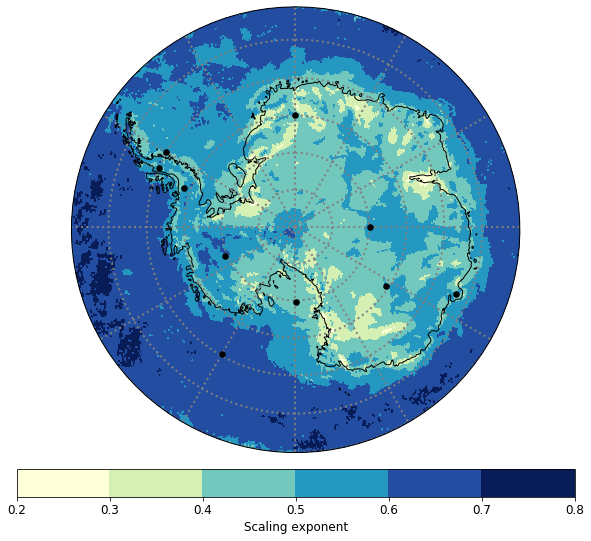

In [149]:
######################################
# Plot Scaling Law Map of Antarctica
######################################

##Create a matrix of exponents
b_matrix = np.zeros(PCP_max[:,:,0].shape)
for i in range(PCP_max.shape[0]):
    for j in range(PCP_max.shape[1]):
        b, a = np.polyfit(np.log(duration),np.log(PCP_max[i,j,:]),1)
        b_matrix[i,j] = b


##Plot
plt.close('all')

#Map parameters
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.stock_img()
ax.coastlines(resolution='50m', color='black', linewidth=1)
gl = ax.gridlines(color='gray', linestyle=':', linewidth=2)
gl.n_steps = 90
gl.xlocator = mticker.FixedLocator([0,30,60,90,120,150,180,210,240,270,300,330,360])
gl.ylocator = mticker.FixedLocator([-60,-65,-70,-75,-80,-85,-90])

#Plot b_matrix
cmap = plt.get_cmap('YlGnBu')
bounds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
norm = colors.BoundaryNorm(bounds, cmap.N)
cs = ax.pcolormesh(lons, lats, b_matrix, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, pad=0.03, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Scaling exponent', fontsize=12)

#Plot points
p_lats = np.array([-75.00, -79.85, -66.73, -75.35, -79.85, -70.26, -79.68, -74.06, -70.01, -69.88])
p_lons = np.array([-0.33, 90.02, 112.75, 123.33, 179.83, -149.99, -112.33, -70.86, -66.73, -60.02])
#ax.plot(p_lons[:], p_lats[:], 'k.', transform=ccrs.PlateCarree())
ax.scatter(p_lons, p_lats, marker='o', c='k', s=30, transform=ccrs.Geodetic(), zorder=200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


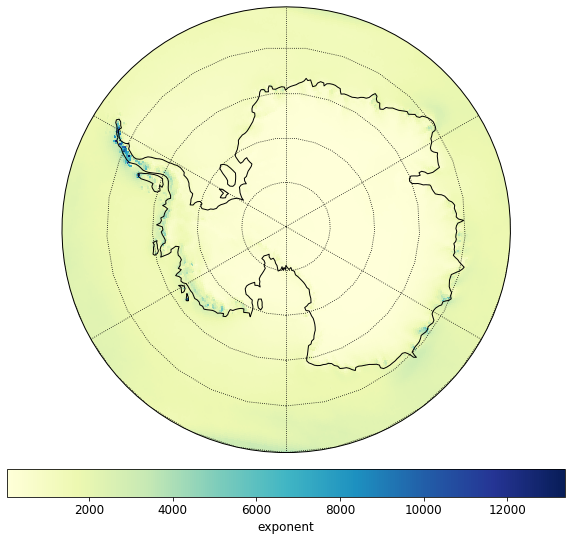

In [124]:
######################################
# Plot Max PCP Map of Antarctica
######################################

##Plot
plt.close('all')

#Map parameters
for j in range(20):
    print(j)
    plt.close('all')
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #Set circle boundary
    theta=np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5,0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts*radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    #ax.add_feature(cartopy.feature.LAND)
    #ax.add_feature(cartopy.feature.OCEAN)
    #ax.stock_img()
    ax.coastlines()
    gl = ax.gridlines(color='k', linestyle=':')
    gl.n_steps = 90

    #Plot b_matrix
    cmap = plt.get_cmap('YlGnBu')
    cs = ax.pcolormesh(lons, lats, PCP_max[:,:,j], cmap=cmap, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, pad=0.03, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('exponent', fontsize=12)

    os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Maps_PCP_'+str(j)+'.png', dpi=300)

[  38.82827461   55.11746407   55.44576645   55.75797558   62.91434392
   75.18005893   78.02385762   84.25820321   87.10200191   87.40668744
   93.67637783  101.24459267  119.29028034  178.50701809  223.3537674
  374.94256496  475.22993088  609.97102261  879.51564789 1073.05698395]
ANTARCTICA
a_sup = [1.07914908], a_inf = [0.58452723]
b = 0.49828678930227027
[  40.44378098   57.12826306   69.91896132   80.6956808    90.1860299
   98.76299193  106.64805487  113.98548723  120.87547288  127.39093911
  155.91305714  179.94418187  220.23267674  311.08640156  380.73690518
  537.80426923  658.21563408  759.66744506  929.75273284 1073.05698395]
WR
a_sup = [73.25969403], a_inf = [40.4525376]
b = 0.4846728478249487
[7.32596940e+01 1.80956853e+05]


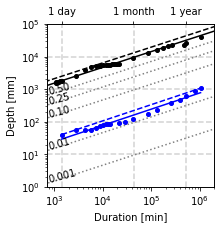

In [129]:
######################################
# Plot Scaling Law of a point
######################################

#args_m90_m170 = np.argwhere(lats == -90)[0]; print(args_m90_m170)

args_7500S_033W_DronningMaudLand = [120, 179]
args_7985S_9002E_HighPlateau = [171, 127]
args_6673S_11275E_LawDome = [222, 100]
args_7535S_12333E_DomeC = [185, 97]
args_7985S_17983E_RossIceShelf = [138, 80]
args_7026S_14999W_Ocean = [103, 46]
args_7968S_11233W_WAISDivide = [ 96, 98]
args_7406S_7086W_Gomez = [ 68, 130]
args_7001S_6673W_WestPeninsula = [ 53, 138]
args_6988S_6002W_EastPeninsula = [ 55, 147]

#print(lons[args_m90_m170args_m7985_m09002[0],args_m7985_m09002[1]]); print(lats[args_m90_m170args_m7985_m09002[0],args_m7985_m09002[1]])
point = args_6988S_6002W_EastPeninsula
pointname = 'East Peninsula'
PCPmax_args = PCP_max[point[0],point[1],:]
print(PCPmax_args)


class SL_Envelop():
    '''----BASIC METHODS----'''
    def __init__(self, duration, record):
        self._duration = duration
        self._record = record
        
    @property
    def duration (self):
        return self._duration     
    
    @property
    def record (self):
        return self._record
     
    def __str__(self):
        return 'DATA\n Duration: ' + self.duration + '\n Record: ' + self.record
    
    def regression(self, complete=False, ftype=0):
        '''Log-Log regression of data'''
        #Fit in log domain
        p = np.polyfit(np.log(self.duration),np.log(self.record),1)
        
        #Compute fit in linear domain (y = e^(p_1 * log(x) + p_2)
        if complete == False:
            y_hat = np.exp(p[0] * np.log(self.duration) + p[1])
        else:
            y_hat = np.exp(p[0] * np.log([1,10000000]) + p[1])
        
        if ftype == 3:
            return y_hat, p[1], p[0]
        elif ftype == 2:
            return p[1], p[0]      
        elif ftype == 1:
            return np.exp(p[1]), p[0]
        else:
            return y_hat, p
    
    def envelope(self, opt='both', range=[1,10000000], complete=False):
        '''Envelop of the supINSay data'''
        
        #Make the regression
        y_hat, a, b = self.regression(complete=False, ftype=3)
        
        #Superior Envelop
        Log_record_sup = np.log(self.record[np.where(self.record > y_hat)])
        Log_duration_sup = np.log(self.duration[np.where(self.record > y_hat)])
        dist = np.abs(b*Log_duration_sup - Log_record_sup + a) / np.sqrt(b**2 + 1)
        Max_record_sup = Log_record_sup[np.where(dist == np.amax(dist))]
        Max_duration_sup = Log_duration_sup[np.where(dist == np.amax(dist))]
        a_sup = b*(-Max_duration_sup) + Max_record_sup

        #Inferior Envelop
        Log_record_inf = np.log(self.record[np.where(self.record < y_hat)])
        Log_duration_inf = np.log(self.duration[np.where(self.record < y_hat)])
        dist = np.abs(b*Log_duration_inf - Log_record_inf + a) / np.sqrt(b**2 + 1)
        Max_record_inf = Log_record_inf[np.where(dist == np.amax(dist))]
        Max_duration_inf = Log_duration_inf[np.where(dist == np.amax(dist))]
        a_inf = b*(-Max_duration_inf) + Max_record_inf

        
        #Calculate the Envelope ecuation
        if complete == False:
            y_hat_sup = np.exp(b * np.log(self.duration) + a_sup)
            y_hat_inf = np.exp(b * np.log(self.duration) + a_inf)
        else:
            y_hat_sup = np.exp(b * np.log(range) + a_sup)
            y_hat_inf = np.exp(b * np.log(range) + a_inf)
        
        print('a_sup = ' + str(np.exp(a_sup)) + ', a_inf = ' + str(np.exp(a_inf)))
        print('b = ' + str(b))
        print(y_hat_sup)
        
        return y_hat_sup, y_hat_inf, a_sup, a_inf, b
        
        #return env_sup, env_inf 
        
    
    def formula(self, ftype=0):
        '''Show formula of regression'''
        _reg, p = self.regression()
        R2 = self.R2()
        b = p[0]
        a = np.exp(p[1])        
        
        #formula = 'y = '+str(np.round(a,2))+' EXP(x^'+str(np.round(b,2))+')'
        if ftype == 0:
            formula = '$y = '+str(np.round(a,2))+' x^{'+str(np.round(b,2))+'}$'
        elif ftype == 1:
            formula = '$b:'+str(np.round(b,2))+'$'
        elif ftype == 2:
            formula = '$b:'+str(np.round(b,2))+' a:'+str(np.round(a,2))+'$'
        elif ftype == 3:
            formula = '$R^{2}:'+str(np.round(R2,2))+'$'
        
        return formula
    
    def exponent(self):
        _reg, p = self.regression()
        b = p[0]
        
        return b
    
    def R2(self):
        X = np.log(np.array(self.duration))
        Y = np.log(np.array(self.record))
        n = np.size(X)
        A = np.sum(X*Y) - 1/n * np.sum(X) * np.sum(Y)
        B = np.sum(X**2) - 1/n * np.sum(X)**2
        C = np.sum(Y**2) - 1/n * np.sum(Y)**2
        
        return A**2 / (B*C)
    
       
def plot_scaling_law(PCPmax, point):    
    #SETTING LINES##
    #Axis
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    ylines = [10,100,1000,10000]
    xlines = [10,60,1440,44640,525600]
    for yline in ylines:
        ax.axhline(yline, linestyle='--', linewidth=1.5, color='LightGray')
    for xline in xlines:
        ax.axvline(xline, linestyle='--', linewidth=1.5, color='LightGray')

    ###ANTARCTICA###
    print('ANTARCTICA')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(duration, PCPmax)
    plt.plot(duration, PCPmax, '.', color='b', markersize=8, label='Antarctica')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(duration,y_hat,'-', color = 'b', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(duration,y_hat_sup,'--', color = 'b', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    #print(BD)
    
    ###WORLD RECORDS###
    print('WR')
    BD = get_sl_data('WR')
    BDdata = SL_Envelop(BD[0,:],BD[1,:])
    plt.plot(BD[0,:],BD[1,:], '.', color = 'k', markersize=8, label='World Extremes')
    y_hat, _pBD= BDdata.regression(complete=True)
    plt.loglog([1,10000000],y_hat,'-', color = 'k', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(complete=True)    
    plt.loglog([1,10000000],y_hat_sup,'--', color = 'k', linewidth=1.5)

    #Percent of max value
    plt.plot([1,10000000],y_hat*0.50,':', color='Gray') #50% of max values
    plt.plot([1,10000000],y_hat*0.25,':', color='Gray') #25% of max values
    plt.plot([1,10000000],y_hat*0.10,':', color='Gray') #10% of max values
    plt.plot([1,10000000],y_hat*0.01,':', color='Gray') #1% of max values
    plt.plot([1,10000000],y_hat*0.001,':', color='Gray') #0.1% of max values
    plt.text(720,600,'0.50', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,300,'0.25', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,120,'0.10', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,12,'0.01', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,1.2,'0.001', fontsize=10, rotation=15, verticalalignment='bottom')
    #plt.legend()
    
    ###PLOT SETTINGS###
    ax.set_xscale("log")#, nonposy="clip")
    ax.set_yscale("log")#, nonposy="clip")
    ax2 = ax.twiny() #Repit axis on top
    ax2.set_xscale('log', subsx=[0])
    #axarr[i,j].set_xscale('log')
    #axarr[i,j].set_yscale('log')
    ax.set_xlabel('Duration [min]', fontsize=10)
    ax.set_ylabel('Depth [mm]', fontsize=10)
    ax2.set_xticks([10, 60, 1440, 43200, 525600])
    ax2.set_xticklabels(['10 min', '1 hour', '1 day', '1 month', '1 year'])
    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #General
    ax.set_xlim(720, 2000000)
    ax2.set_xlim(720, 2000000)
    #plt.xlim(1,2000000)
    plt.ylim(1,100000)
    #ax.legend(loc=4, fontsize=10)
    os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Envelope_'+pointname+'.png', dpi=300)

def get_sl_data(country):
    #Folder
    os.chdir('D:\\Bigfiles\\RACMO2_PCP')
    #Read data
    BD = np.loadtxt('Max_'+country+'.csv',delimiter=';')    
    return BD    

plot_scaling_law(PCPmax_args, pointname)

In [120]:
[131, 120]

[131, 120]

In [37]:

args_m7500_m033 = np.argwhere(lats == lats.flat[np.abs(lats+66.73).argmin()])[0]; print(args_m7500_m033), print(lons[args_m7500_m033[0],args_m7500_m033[1]])
PCP_max[args_m90_m170[0],args_m90_m170[1],:]

[ 38 116]
-82.53189849853516


array([  3.5345614 ,   6.45307302,   8.98438096,  10.52386165,
        11.508286  ,  12.49271035,  13.4914577 ,  14.47588205,
        15.46030641,  15.94680548,  17.04871058,  17.59781241,
        21.6694057 ,  32.72820711,  38.58148456,  64.83597904,
        85.37487388, 110.89330316, 146.23384774, 185.26300639])

In [108]:
args_lat_m6673_11275 = np.argwhere(np.round(lats,2) == -79.85); 
args_lon_m6673_11275 = np.argwhere(np.round(lons,2) == 179.83);

prova = [138, 80]
print(lats[prova[0],prova[1]])
print(lons[prova[0],prova[1]])

print(args_lat_m6673_11275)
print(args_lon_m6673_11275)
print(lats[args_lat_m6673_11275[0][0],args_lat_m6673_11275[0][1]])
print(lons[args_lon_m6673_11275[0][0],args_lon_m6673_11275[0][1]])


#print(args_lon_m6673_11275)

-79.84956359863281
-179.8257293701172
[[ 91 113]
 [ 91 127]
 [124  80]
 [124 160]
 [138  80]
 [138 160]
 [171 113]
 [171 127]]
[[147  35]]
-79.84956359863281
179.8305206298828
